C:\Users\otsuka\anaconda3\envs\scraping\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\otsuka\anaconda3\envs\scraping\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\otsuka\anaconda3\envs\scraping\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\otsuka\anaconda3\envs\scraping\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: 

k = 2, Silhouette Score = 0.290
k = 3, Silhouette Score = 0.334
k = 4, Silhouette Score = 0.420
k = 5, Silhouette Score = 0.418
k = 6, Silhouette Score = 0.407
k = 7, Silhouette Score = 0.410

Table D-1: Cluster Evaluation Scores
   Clusters (k)  Silhouette Score     WSS
0             2             0.290  20.433
1             3             0.334  15.007
2             4             0.420  10.049
3             5             0.418   8.644
4             6             0.407   7.414
5             7             0.410   6.167

Figure D-1: Cluster Evaluation Plots


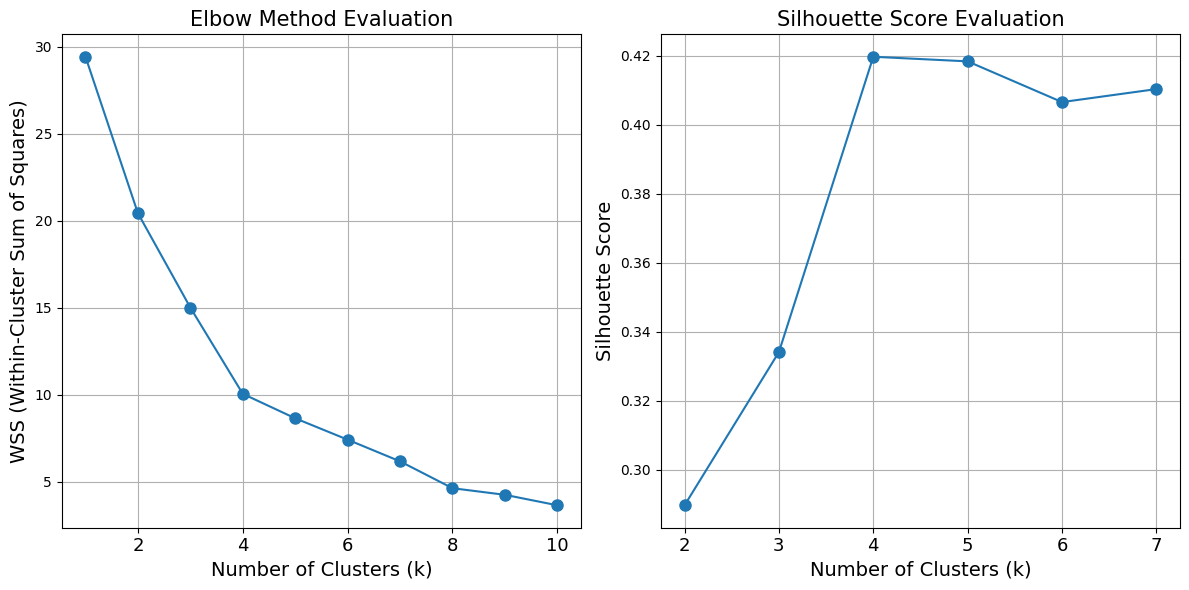

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load data
df = pd.read_csv('official_row_data.csv', encoding='utf-8')

# Create pivot table: each column is model-session
df_cross = (
    df
    .set_index(['story', 'model', 'session'])['score']
    .unstack(['model', 'session'])
    .reset_index()
)

# Rename columns to 'model-session'
df_cross.columns = [
    col if isinstance(col, str) else f"{col[0]}-{col[1]}"
    for col in df_cross.columns
]

# Extract feature matrix and feature names
story_titles = df_cross['story-'].values
X_raw = df_cross.drop('story-', axis=1).values
feature_names = df_cross.columns[1:].tolist()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Convert loadings to DataFrame
max_pcs = min(4, len(feature_names))
loadings_df = pd.DataFrame(
    loadings[:, :max_pcs],
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(max_pcs)]
)

# Prepare data for clustering (PC1–PC4)
X = loadings_df[['PC1', 'PC2', 'PC3', 'PC4']].values
X_rounded = loadings_df[['PC1', 'PC2', 'PC3', 'PC4']].round(3)

# Silhouette score for k = 2 to 7
silhouette_scores = []
k_range_silhouette = range(2, 8)

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_rounded.values)
    score = silhouette_score(X_rounded, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.3f}")

# WSS for elbow method (k = 1 to 10)
wss = []
k_range_elbow = range(1, 11)

for k in k_range_elbow:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

# Create result table
cluster_range = list(range(2, 8))
wss_subset = wss[1:7]  # for k=2 to 7

df_result = pd.DataFrame({
    "Clusters (k)": cluster_range,
    "Silhouette Score": silhouette_scores,
    "WSS": wss_subset
}).round(3)

print("\nTable D-1: Cluster Evaluation Scores")
print(df_result)

# Plot Figure D-1
plt.figure(figsize=(12, 6))

# Subplot 1: Elbow Method
plt.subplot(1, 2, 1)
plt.plot(k_range_elbow, wss, 'o-', markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('WSS (Within-Cluster Sum of Squares)', fontsize=14)
plt.title('Elbow Method Evaluation', fontsize=15)
plt.xticks(fontsize=13)
plt.grid(True)

# Subplot 2: Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, 'o-', markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Score Evaluation', fontsize=15)
plt.xticks(fontsize=13)
plt.grid(True)

plt.tight_layout()
print("\nFigure D-1: Cluster Evaluation Plots")
plt.show()
